# AVO

## Programa (afim de ser interativo) no Jupyter Lab para explorar os conceitos de AVO (Amplitude Versus Offset) e Tuning em Camadas Finas, baseado no artigo de Hamlyn (2014)

> Thin Beds, Tuning and AVO - Hamlyn (2014) | Geophysical Tutorial Coordinated by Matt Hall | The Leading Edge - SEG
> 
> https://library.seg.org/doi/10.1190/tle33121394.1

> Repositório: https://github.com/seg/tutorials-2014/tree/master/1412_Tuning_and_AVO  
> Repositório: https://github.com/seg
> 
> Mini Conda Evita problemas de versões de python

### Sumário e Instruções de Uso

Este notebook implementa a exploração interativa dos conceitos de **Tuning em Camadas Finas** e **Análise AVO (Amplitude Versus Offset)**, baseada no tutorial de Wes Hamlyn (2014).

### Seção 2: Exploração de Tuning (Zero-Offset)
- **Objetivo:** Determinar a espessura de *tuning* ($\mathbf{\lambda/4}$) para diferentes frequências e contrastes de impedância.
- **Interação:** Use os *sliders* para mudar a **Frequência Central** da wavelet e as propriedades $\mathbf{V_P}$ e $\mathbf{\rho}$ da camada 2 (alvo).
- **Resultado:** O gráfico **Curva de Amplitude vs. Espessura** indicará dinamicamente a Espessura de Tuning.

### Seção 3: Exploração AVO Interativa (Pré-Empilhamento)
- **Objetivo:** Analisar como o *tuning* e as propriedades elásticas ($\mathbf{V_S}$ é fundamental) afetam o sismograma em diferentes ângulos.
- **Interação:** Use os *sliders* para variar a **Espessura (m)** e as propriedades $\mathbf{V_P}$, $\mathbf{V_S}$ e $\mathbf{\rho}$.
- **Resultado:** Observe o **AVO Gather** (sismograma vs. ângulo) e a **Curva AVO** para a interface superior (L1/L2), com a classificação AVO calculada dinamicamente.

A chave para um "Programa interativo no Jupyter Lab" é o uso eficiente do ipywidgets.interact. O código atual executa um script completo de uma vez, gerando apenas um resultado estático. Para torná-lo interativo, é preciso encapsular a lógica de modelagem dentro de funções Python no notebook e expor os parâmetros como sliders.

## 1. Configuração e Importação de Bibliotecas

In [1]:
# Verificar versão do Python e instalação do Jupyter
import sys
print(f"Python version: {sys.version}")

Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]


In [2]:
# Importanto Bibliotecas/Pacotes:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal # Para a função Ricker
from ipywidgets import interact, interactive, fixed, IntSlider, FloatSlider, Layout
from IPython.display import display

# Configuração visual para plots (opcional, mas recomendado)
plt.style.use('seaborn-v0_8-whitegrid') 
%matplotlib inline

In [3]:
# Baixar os scripts do tutorial do GitHub
# Baixar APENAS os scripts específicos do tutorial de Tuning e AVO

import urllib.request
import os

# Criar Diretório Para os Scripts:
if not os.path.exists('tuning_scripts'):
    os.makedirs('tuning_scripts')

# URLs diretas para os scripts específicos do tutorial 1412_Tuning_and_AVO:
scripts = {
    'tuning_wedge.py': 'https://raw.githubusercontent.com/seg/tutorials-2014/master/1412_Tuning_and_AVO/tuning_wedge.py',
    'tuning_prestack.py': 'https://raw.githubusercontent.com/seg/tutorials-2014/master/1412_Tuning_and_AVO/tuning_prestack.py'
}

print("Baixando scripts específicos do tutorial Thin Beds, Tuning and AVO...")

# Baixar cada script:
success_count = 0
for filename, url in scripts.items():
    try:
        urllib.request.urlretrieve(url, f'tuning_scripts/{filename}')
        print(f'✓ {filename} baixado com sucesso!')
        success_count += 1
    except Exception as e:
        print(f'✗ Erro ao baixar {filename}: {e}')

print(f"\nTotal de scripts baixados: {success_count}/{len(scripts)}")

Baixando scripts específicos do tutorial Thin Beds, Tuning and AVO...
✓ tuning_wedge.py baixado com sucesso!
✓ tuning_prestack.py baixado com sucesso!

Total de scripts baixados: 2/2


In [6]:
# Verificar o conteúdo baixado:

import os

print("Estrutura de Diretórios:")
print(f"Diretório Atual: {os.getcwd()}")

if os.path.exists('tuning_scripts'):
    print("\nConteúdo de 'tuning_scripts':")
    print()
    files = os.listdir('tuning_scripts')
    for file in files:
        file_path = os.path.join('tuning_scripts', file)
        file_size = os.path.getsize(file_path)
        print(f"  {file} ({file_size} bytes)")
        
    if len(files) == 0:
        print("  (vazio)")
else:
    print("Diretório 'tuning_scripts' não encontrado")

Estrutura de Diretórios:
Diretório Atual: C:\Users\Musa Deck\Documents\PYTHON\ON

Conteúdo de 'tuning_scripts':

  tuning_prestack.py (14850 bytes)
  tuning_wedge.py (7788 bytes)


In [4]:
# Vamos dar uma olhada rápida no conteúdo do primeiro script:

if os.path.exists('tuning_scripts/tuning_wedge.py'):
    print("=== Primeiras linhas de tuning_wedge.py ===")
    with open('tuning_scripts/tuning_wedge.py', 'r') as f:
        for i, line in enumerate(f):
            if i < 10:  # Mostrar primeiras 10 linhas
                print(f"{i+1:3d}: {line.rstrip()}")
            else:
                print("... (continua)")
                break
else:
    print("Arquivo tuning_wedge.py não encontrado")

=== Primeiras linhas de tuning_wedge.py ===
  1: """
  2: Python script to generate a zero-offset synthetic from a 3-layer wedge model.
  3: 
  4: Created by:    Wes Hamlyn
  5: Create Date:   19-Aug-2014
  6: Last Mod:      1-Nov-2014
  7: 
  8: This script is provided without warranty of any kind.
  9: 
 10: """
... (continua)


> IMPORTANTE: Python Version !! Teremos que passar de Python 2 para Python 3 !!

### tuning_wedge.py:

In [5]:
# Examinar o script tuning_wedge.py completo:

if os.path.exists('tuning_scripts/tuning_wedge.py'):
    print("=== Conteúdo completo de tuning_wedge.py ===")
    with open('tuning_scripts/tuning_wedge.py', 'r') as f:
        content = f.read()
        print(content)
else:
    print("Arquivo tuning_wedge.py não encontrado")

=== Conteúdo completo de tuning_wedge.py ===
"""
Python script to generate a zero-offset synthetic from a 3-layer wedge model.

Created by:    Wes Hamlyn
Create Date:   19-Aug-2014
Last Mod:      1-Nov-2014

This script is provided without warranty of any kind.

"""


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec



###########################################################
#
#       DEFINE MODELING PARAMETERS HERE
#


#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]
vp_mod = [2500.0, 2600.0, 2550.0]  # P-wave velocity (m/s)
vs_mod = [1200.0, 1300.0, 1200.0]  # S-wave velocity (m/s)
rho_mod= [1.95, 2.0, 1.98]         # Density (g/cc)

dz_min = 0.0   # Minimum thickness of Layer 2 (m)
dz_max = 60.0  # Maximum thickness of Layer 2 (m)
dz_step= 1.0   # Thickness step from trace-to-trace (normally 1.0 m)


#   Ricker Wavelet Parameters
wvlt_length= 0.128
wvlt_cfreq = 30.0
wvlt_phase = 0.0


#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 #

In [6]:
# Fazer uma correção para Python 3 (print statement)
# Corrigir todos os problemas identificados:
try:
    # Ler o conteúdo original
    with open('tuning_scripts/tuning_wedge.py', 'r') as f:
        content = f.read()
    
    # Correção 1: print statement
    content = content.replace('print "finished step %i" % (model)', 'print("finished step %i" % (model))')
    
    # Correção 2: Problema no linspace - linha 117
    content = content.replace(
        't = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)', 
        't = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, int(wvlt_length/dt))'
    )
    
    # Correção 3: Outro linspace - linha 186
    content = content.replace(
        't = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)', 
        't = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, int(wvlt_length/dt))'
    )
    
    # Salvar versão corrigida
    with open('tuning_scripts/tuning_wedge_py3.py', 'w') as f:
        f.write(content)
    
    print("✓ Script corrigido para Python 3 !!")
    
except Exception as e:
    print(f"Erro ao corrigir: {e}")

✓ Script corrigido para Python 3 !!


## 2. Efeito Tuning (Zero-Offset)

### tuning_wedge_py3.py
FUNCTIONS DEFINITIONS: ricker, calc_rc, plot_vawig

PARAMETERS: Vp, Vs, Rho, cfreq

Computations & Plotting: executa a modelagem (convolução) e gera o gráfico

### Tuning:
tuning_wedge_py3.py

tuning_wedge_py3.py
--------------------------------------------------


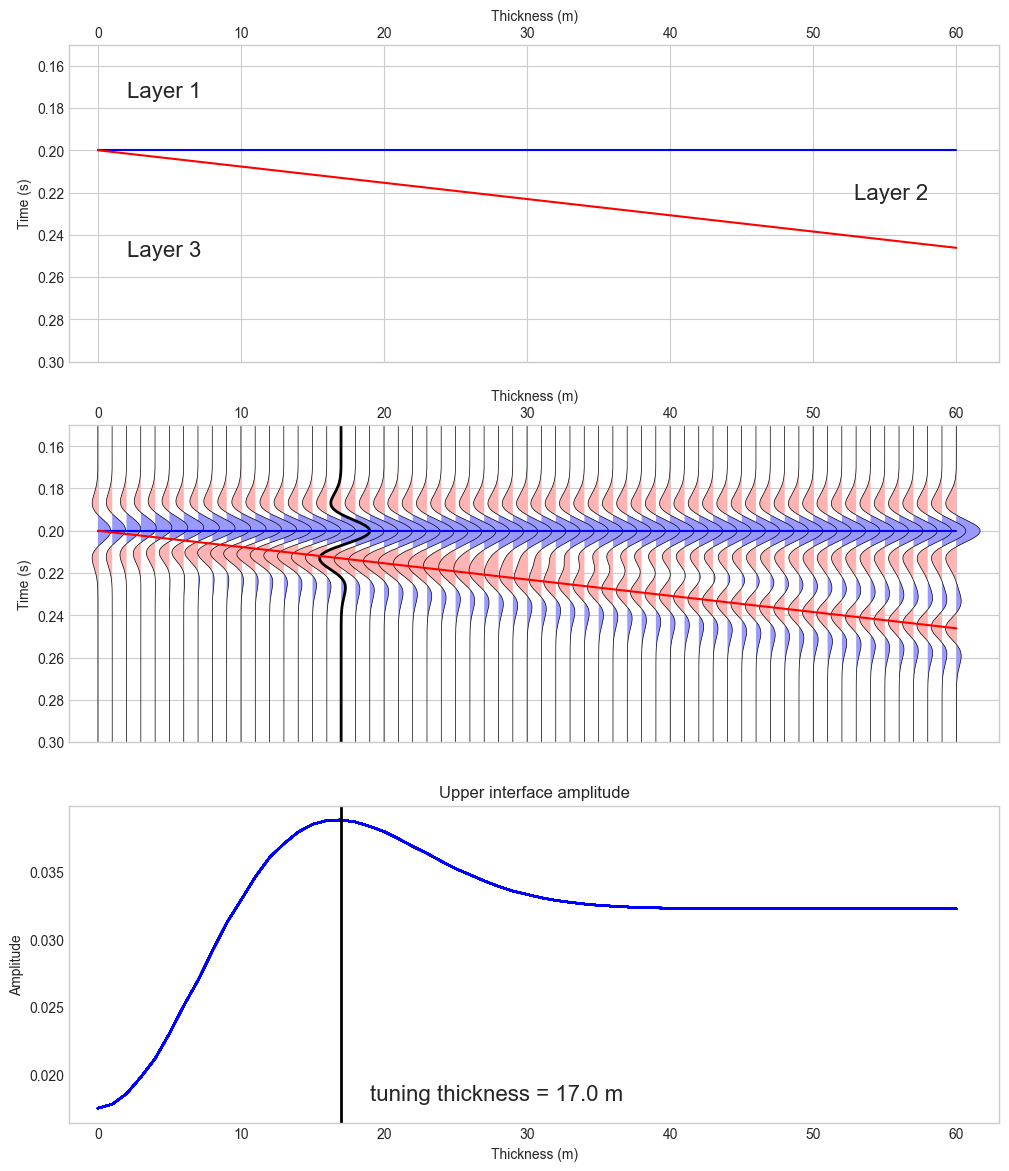

In [7]:
# Executar a versão corrigida em python 3:
import io
from contextlib import redirect_stdout
# Executando tuning_wedge_py3.py (Saída de console suprimida)...
# finished step 0, finished step 1, finished step 2, ... ...

print("tuning_wedge_py3.py")
print("-" * 50)

try:
    # 1. Abre um buffer de memória para capturar o que seria impresso no console
    f = io.StringIO()
    
    # 2. Usa redirect_stdout para desviar todos os 'prints' para o buffer 'f'
    with redirect_stdout(f):
        exec(open('tuning_scripts/tuning_wedge_py3.py').read())
        """ o código acima executa o programa todo derando um resultado estático"""
    
    # O conteúdo do buffer (f.getvalue()) pode ser ignorado ou inspecionado,
    # mas não será exibido no seu notebook.
    
except Exception as e:
    print(f"\n✗ Erro ao executar o script: {e}")
    import traceback
    traceback.print_exc()

### Compreendendo os resultados:

In [8]:
# Analisar o que aprendemos com o modelo de cunha:

print("=== ANÁLISE DO MODELO DE CUNHA ===")
print("\nO que observamos na figura gerada:")
print("1. 🎯 TOPO: Mostra as interfaces das camadas no domínio do tempo")
print("2. 📊 MEIO: Sismograma sintético com efeito de tuning")
print("3. 📈 BASE: Amplitude na interface superior vs espessura")

print("\n📖 CONCEITOS-CHAVE COMPROVADOS:")
print("✓ Efeito TUNING: Quando a camada é fina (<40m), as reflexões do topo e base interferem")
print("✓ Espessura de Tuning: ~17m (onde a amplitude é máxima)")
print("✓ Acima de 40m: Reflexões discretas sem interferência")
print("✓ Abaixo de 17m: Interferência destrutiva")

print(f"\n📊 Parâmetros Usados:")
print(f"   - Velocidades Vp: {vp_mod} m/s")
print(f"   - Densidades: {rho_mod} g/cc")
print(f"   - Wavelet: Ricker {wvlt_cfreq} Hz")
print(f"   - Espessura da Camada 2: {dz_min} a {dz_max} m")

=== ANÁLISE DO MODELO DE CUNHA ===

O que observamos na figura gerada:
1. 🎯 TOPO: Mostra as interfaces das camadas no domínio do tempo
2. 📊 MEIO: Sismograma sintético com efeito de tuning
3. 📈 BASE: Amplitude na interface superior vs espessura

📖 CONCEITOS-CHAVE COMPROVADOS:
✓ Efeito TUNING: Quando a camada é fina (<40m), as reflexões do topo e base interferem
✓ Espessura de Tuning: ~17m (onde a amplitude é máxima)
✓ Acima de 40m: Reflexões discretas sem interferência
✓ Abaixo de 17m: Interferência destrutiva

📊 Parâmetros Usados:
   - Velocidades Vp: [2500.0, 2600.0, 2550.0] m/s
   - Densidades: [1.95, 2.0, 1.98] g/cc
   - Wavelet: Ricker 30.0 Hz
   - Espessura da Camada 2: 0.0 a 60.0 m


### Calculando os Coeficientes de Reflexão Manualmente para Entender:

In [9]:
# Calcular os coeficientes de reflexão manualmente para entender

print("\n" + "="*50)
print("CÁLCULO DOS COEFICIENTES DE REFLEXÃO")
print("="*50)

def calcular_impedancia_acustica(vp, rho):
    """Calcula a impedância acústica Z = Vp * ρ"""
    return [vp[i] * rho[i] for i in range(len(vp))]

def calcular_coeficientes_reflexao(vp, rho):
    """Calcula coeficientes de reflexão usando a fórmula de Zoeppritz simplificada"""
    Z = calcular_impedancia_acustica(vp, rho)
    rc = []
    for i in range(len(Z)-1):
        rc_value = (Z[i+1] - Z[i]) / (Z[i+1] + Z[i])
        rc.append(rc_value)
    return rc, Z

# Calcular
rc, Z = calcular_coeficientes_reflexao(vp_mod, rho_mod)

print("Impedâncias acústicas:")
for i, z in enumerate(Z):
    print(f"   Camada {i+1}: {z:.0f} m/s·g/cc")

print("\nCoeficientes de reflexão:")
print(f"   Interface 1-2 (topo): {rc[0]:.4f}")
print(f"   Interface 2-3 (base): {rc[1]:.4f}")

print(f"\n💡 Interpretação:")
if rc[0] > 0:
    print("   Topo: Aumento de impedância (refletor 'duro')")
else:
    print("   Topo: Diminuição de impedância (refletor 'macio')")
    
if rc[1] > 0:
    print("   Base: Aumento de impedância (refletor 'duro')")
else:
    print("   Base: Diminuição de impedância (refletor 'macio')")


CÁLCULO DOS COEFICIENTES DE REFLEXÃO
Impedâncias acústicas:
   Camada 1: 4875 m/s·g/cc
   Camada 2: 5200 m/s·g/cc
   Camada 3: 5049 m/s·g/cc

Coeficientes de reflexão:
   Interface 1-2 (topo): 0.0323
   Interface 2-3 (base): -0.0147

💡 Interpretação:
   Topo: Aumento de impedância (refletor 'duro')
   Base: Diminuição de impedância (refletor 'macio')


### Exploração do Conceito de Tuning (Interactive Wedge)


VISUALIZANDO O EFEITO TUNING



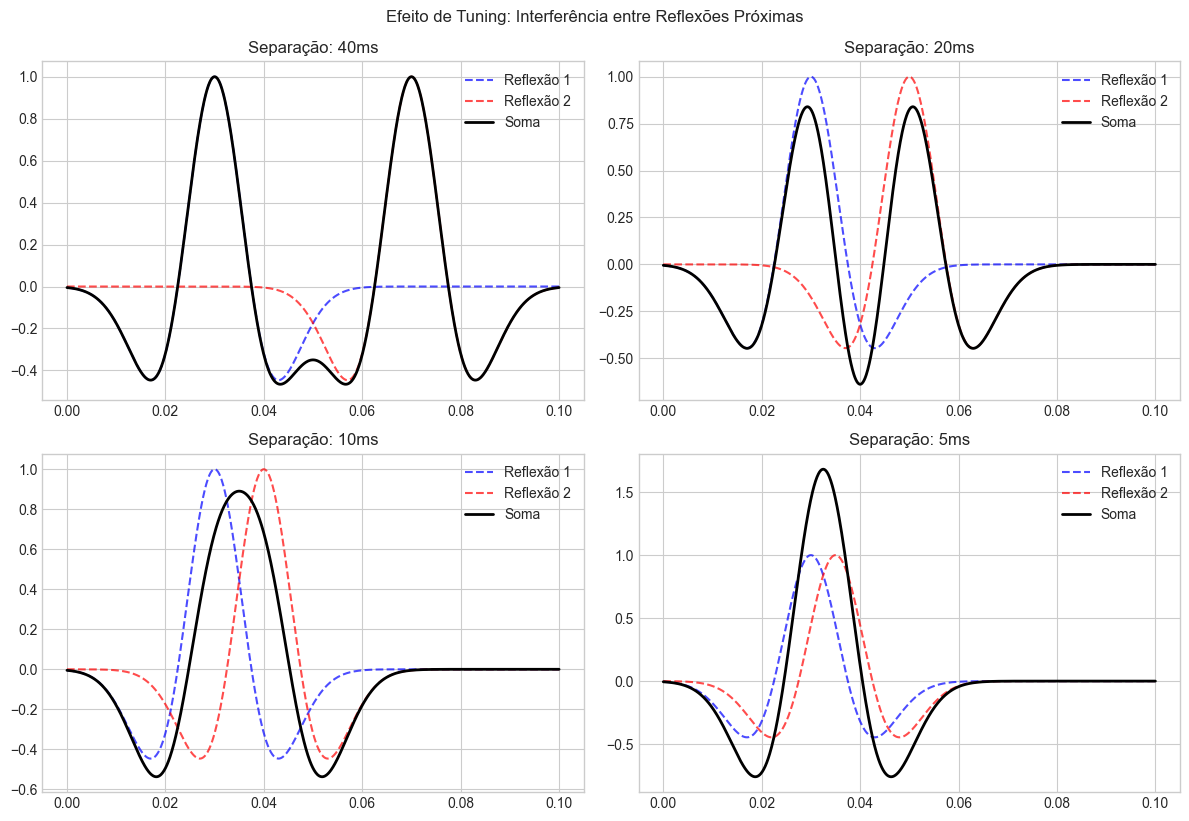

📚 Observações:

• Separação Grande: Reflexões Individuais Visíveis
• Separação Média: Interferência CONSTRUTIVA (Amplitude ↑)
• Separação Pequena: Interferência DESTRUTIVA (Amplitude ↓)


In [10]:
# Visualizar o conceito de tuning com um exemplo simples:

print("\n" + "="*50)
print("VISUALIZANDO O EFEITO TUNING")
print("="*50)
print()

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Criar um exemplo simplificado de duas reflexões se aproximando
t = np.linspace(0, 0.1, 1000)  # 100 ms
freq = 30  # Hz

# Duas reflexões com diferentes separações
separations = [0.04, 0.02, 0.01, 0.005]  # 40ms, 20ms, 10ms, 5ms

plt.figure(figsize=(12, 8))

for i, sep in enumerate(separations):
    # Criar duas wavelets Ricker separadas
    wavelet1 = (1 - 2*(np.pi*freq*(t-0.03))**2) * np.exp(-(np.pi*freq*(t-0.03))**2)
    wavelet2 = (1 - 2*(np.pi*freq*(t-0.03-sep))**2) * np.exp(-(np.pi*freq*(t-0.03-sep))**2)
    
    # Soma (interferência)
    combined = wavelet1 + wavelet2
    
    plt.subplot(2, 2, i+1)
    plt.plot(t, wavelet1, 'b--', alpha=0.7, label='Reflexão 1')
    plt.plot(t, wavelet2, 'r--', alpha=0.7, label='Reflexão 2')
    plt.plot(t, combined, 'k-', linewidth=2, label='Soma')
    plt.title(f'Separação: {sep*1000:.0f}ms')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Efeito de Tuning: Interferência entre Reflexões Próximas', y=1.02)
plt.show()

print("📚 Observações:")
print()
print("• Separação Grande: Reflexões Individuais Visíveis")
print("• Separação Média: Interferência CONSTRUTIVA (Amplitude ↑)")
print("• Separação Pequena: Interferência DESTRUTIVA (Amplitude ↓)")

In [12]:
# Resumo do aprendizado
print("\n" + "="*60)
print("RESUMO DO APRENDIZADO - MODELO DE CUNHA")
print("="*60)

print("\n🎯 O QUE APRENDEMOS:")
print("1. 📐 Geometria: Modelo de 3 camadas com camada 2 variável")
print("2. 🌊 Wavelet: Ricker 30Hz usada para convolução")
print("3. 🔁 Convolução: Wavelet * coeficientes de reflexão = sismograma")
print("4. ⚡ Tuning: Interferência entre reflexões de topo e base")

print("\n📈 RESULTADOS ESPERADOS:")
print("   • Espessura > 40m: Reflexões separadas")
print("   • Espessura ~17m: Amplitude MÁXIMA (tuning)")
print("   • Espessura < 17m: Amplitude diminui")

print("\n🔬 PRÓXIMO PASSO:")
print("   • Corrigir e executar script AVO")
print("   • Ver efeito do tuning em diferentes ângulos")
print("   • Analisar parâmetros R₀ e G do AVO")

print("\n✅ STATUS ATUAL: Modelo de cunha entendido e executado!")


RESUMO DO APRENDIZADO - MODELO DE CUNHA

🎯 O QUE APRENDEMOS:
1. 📐 Geometria: Modelo de 3 camadas com camada 2 variável
2. 🌊 Wavelet: Ricker 30Hz usada para convolução
3. 🔁 Convolução: Wavelet * coeficientes de reflexão = sismograma
4. ⚡ Tuning: Interferência entre reflexões de topo e base

📈 RESULTADOS ESPERADOS:
   • Espessura > 40m: Reflexões separadas
   • Espessura ~17m: Amplitude MÁXIMA (tuning)
   • Espessura < 17m: Amplitude diminui

🔬 PRÓXIMO PASSO:
   • Corrigir e executar script AVO
   • Ver efeito do tuning em diferentes ângulos
   • Analisar parâmetros R₀ e G do AVO

✅ STATUS ATUAL: Modelo de cunha entendido e executado!


## 3. Análise AVO Pré-Empilhamento (Prestack)

Iniciar o trabalho com o script tuning_prestack.py e o modelo AVO.